# Model import using the Petab format

In this notebook, we illustrate how to use [pyPESTO](https://github.com/icb-dcm/pypesto.git) together with [PEtab](https://github.com/petab-dev/petab.git) and [AMICI](https://github.com/icb-dcm/amici.git). We employ models from the [benchmark collection](https://github.com/benchmarking-initiative/benchmark-models-petab), which we first download:

In [1]:
# install if not done yet
# !apt install libatlas-base-dev swig
!pip install pypesto[amici,petab] --quiet
!pip install git+https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab.git@master#subdirectory=src/python --quiet

In [2]:
import os

import amici
import benchmark_models_petab as models
import matplotlib.pyplot as plt
import numpy as np
import petab

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize

## Import

### Manage PEtab model

A PEtab problem comprises all the information on the model, the data and the parameters to perform parameter estimation. We import a model as a `petab.Problem`.

In [3]:
# a collection of models that can be simulated

# model_name = "Zheng_PNAS2012"
model_name = "Boehm_JProteomeRes2014"
# model_name = "Fujita_SciSignal2010"
# model_name = "Sneyd_PNAS2002"
# model_name = "Borghans_BiophysChem1997"
# model_name = "Elowitz_Nature2000"
# model_name = "Crauste_CellSystems2017"
# model_name = "Lucarelli_CellSystems2018"
# model_name = "Schwen_PONE2014"
# model_name = "Blasi_CellSystems2016"

# the yaml configuration file links to all needed files
yaml_config = os.path.join(models.MODELS_DIR, model_name, model_name + ".yaml")

# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

### Import model to AMICI

The model must be imported to pyPESTO and AMICI. Therefore, we create a `pypesto.PetabImporter` from the problem, and create an AMICI model.

In [4]:
importer = pypesto.petab.PetabImporter(petab_problem)

model = importer.create_model()

# some model properties
print("Model parameters:", list(model.getParameterIds()), "\n")
print("Model const parameters:", list(model.getFixedParameterIds()), "\n")
print("Model outputs:   ", list(model.getObservableIds()), "\n")
print("Model states:    ", list(model.getStateIds()), "\n")

Model parameters: ['Epo_degradation_BaF3', 'k_exp_hetero', 'k_exp_homo', 'k_imp_hetero', 'k_imp_homo', 'k_phos', 'ratio', 'specC17', 'noiseParameter1_pSTAT5A_rel', 'noiseParameter1_pSTAT5B_rel', 'noiseParameter1_rSTAT5A_rel'] 

Model const parameters: [] 

Model outputs:    ['pSTAT5A_rel', 'pSTAT5B_rel', 'rSTAT5A_rel'] 

Model states:     ['STAT5A', 'STAT5B', 'pApB', 'pApA', 'pBpB', 'nucpApA', 'nucpApB', 'nucpBpB'] 



### Create objective function

To perform parameter estimation, we need to define an objective function, which integrates the model, data, and noise model defined in the PEtab problem.

In [5]:
import libsbml

converter_config = libsbml.SBMLLocalParameterConverter().getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

obj = importer.create_objective()

# for some models, hyperparamters need to be adjusted
# obj.amici_solver.setMaxSteps(10000)
# obj.amici_solver.setRelativeTolerance(1e-7)
# obj.amici_solver.setAbsoluteTolerance(1e-7)

We can request variable derivatives via `sensi_orders`, or function values or residuals as specified via `mode`. Passing `return_dict`, we obtain the direct result of the AMICI simulation.

In [6]:
ret = obj(
    petab_problem.x_nominal_scaled,
    mode="mode_fun",
    sensi_orders=(0, 1),
    return_dict=True,
)
print(ret)

{'fval': 138.2219980294295, 'grad': array([ 2.20274530e-02,  5.53227528e-02,  5.78847162e-03,  5.39469425e-03,
       -4.51595808e-05,  7.91355271e-03, -1.08227697e+02,  1.07805861e-02,
        2.40364922e-02,  1.91910805e-02, -1.87147661e+02]), 'rdatas': [<amici.numpy.ReturnDataView object at 0x7fd9001582e0>]}


The problem defined in PEtab also defines the fixing of parameters, and parameter bounds. This information is contained in a `pypesto.Problem`.

In [7]:
problem = importer.create_problem(obj)

In particular, the problem accounts for the fixing of parametes.

In [8]:
print(problem.x_fixed_indices, problem.x_free_indices)

[6, 10] [0, 1, 2, 3, 4, 5, 7, 8, 9]


The problem creates a copy of he objective function that takes into account the fixed parameters. The objective function is able to calculate function values and derivatives. A finite difference check whether the computed gradient is accurate:

In [9]:
objective = problem.objective
ret = objective(petab_problem.x_nominal_free_scaled, sensi_orders=(0, 1))
print(ret)

(138.2219980294295, array([ 2.20274530e-02,  5.53227528e-02,  5.78847162e-03,  5.39469425e-03,
       -4.51595808e-05,  7.91355271e-03,  1.07805861e-02,  2.40364922e-02,
        1.91910805e-02]))


In [10]:
eps = 1e-4


def fd(x):
    grad = np.zeros_like(x)
    j = 0
    for i, xi in enumerate(x):
        mask = np.zeros_like(x)
        mask[i] += eps
        valinc, _ = objective(x + mask, sensi_orders=(0, 1))
        valdec, _ = objective(x - mask, sensi_orders=(0, 1))
        grad[j] = (valinc - valdec) / (2 * eps)
        j += 1
    return grad


fdval = fd(petab_problem.x_nominal_free_scaled)
print("fd: ", fdval)
print("l2 difference: ", np.linalg.norm(ret[1] - fdval))

fd:  [0.01251672 0.05435043 0.01127778 0.00407248 0.00251655 0.0048468
 0.01077928 0.02403519 0.01918978]
l2 difference:  0.011800321299268538


### In short

All of the previous steps can be shortened by directly creating an importer object and then a problem:

In [11]:
importer = pypesto.petab.PetabImporter.from_yaml(yaml_config)
problem = importer.create_problem()

## Run optimization

Given the problem, we can perform optimization. We can specify an optimizer to use, and a parallelization engine to speed things up.

In [12]:
optimizer = optimize.ScipyOptimizer()

# engine = pypesto.engine.SingleCoreEngine()
engine = pypesto.engine.MultiProcessEngine()

# do the optimization
result = optimize.minimize(
    problem=problem, optimizer=optimizer, n_starts=10, engine=engine
)

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
Performing parallel task execution on 8 processes.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 297.75it/s]
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 207.888 and h = 9.53144e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 207.888429:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 207.888 and h = 9.53144e-06, the error test failed repeatedly or with |h| = hmin. 

## Visualize

The results are contained in a `pypesto.Result` object. It contains e.g. the optimal function values.

In [13]:
result.optimize_result.fval

[147.5446729318192,
 149.5885522003661,
 150.6716033176283,
 158.81214766267092,
 164.44212408287493,
 249.74595639607963,
 249.7459974417437,
 249.7459974424775,
 249.74599747132623,
 260.2697018742319]

We can use the standard pyPESTO plotting routines to visualize and analyze the results.

<AxesSubplot: title={'center': 'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

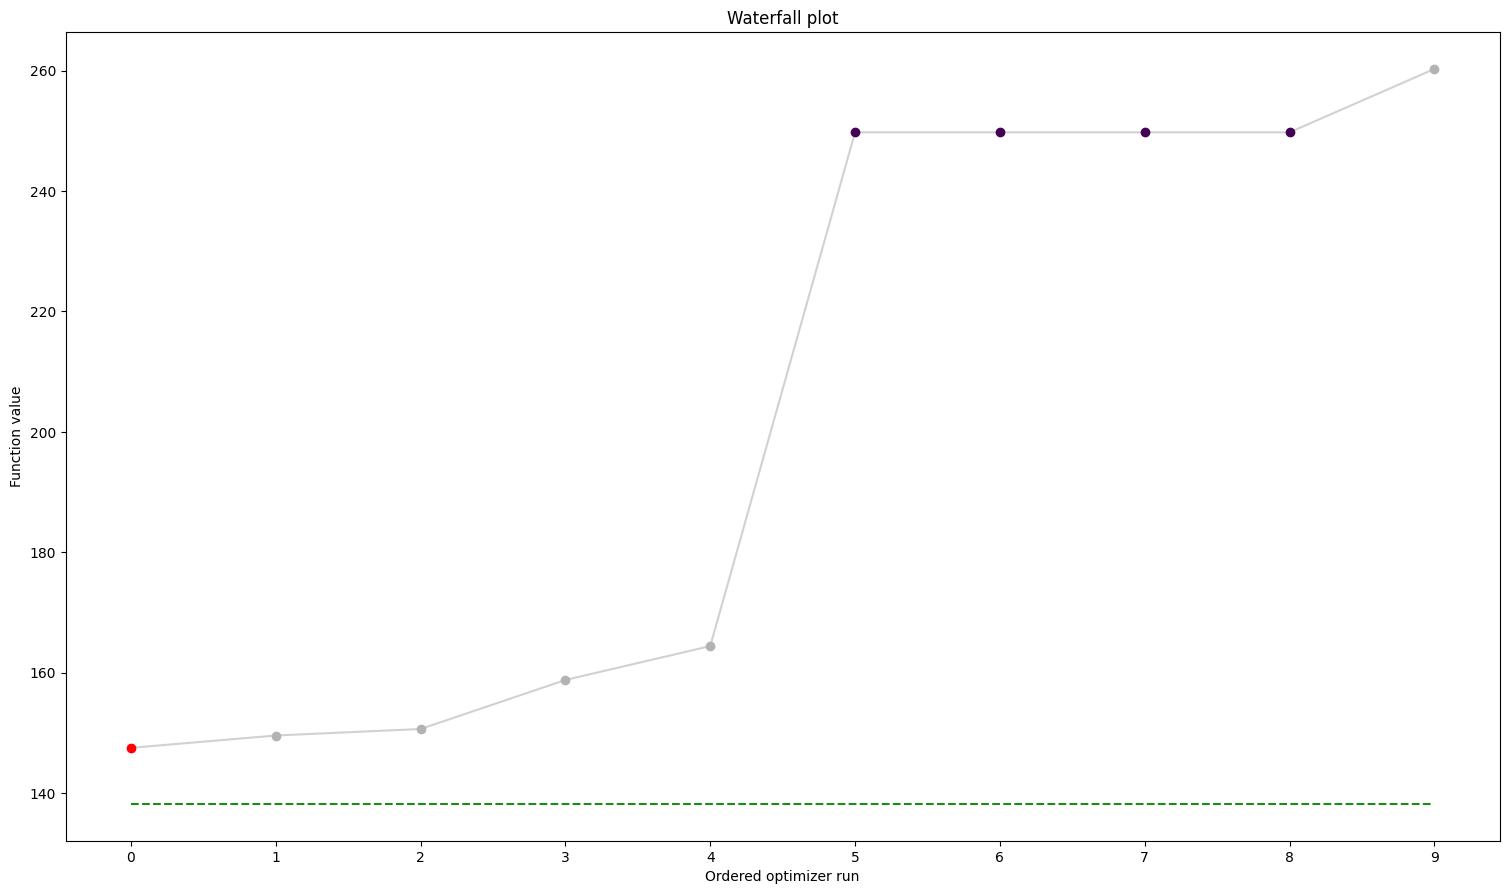

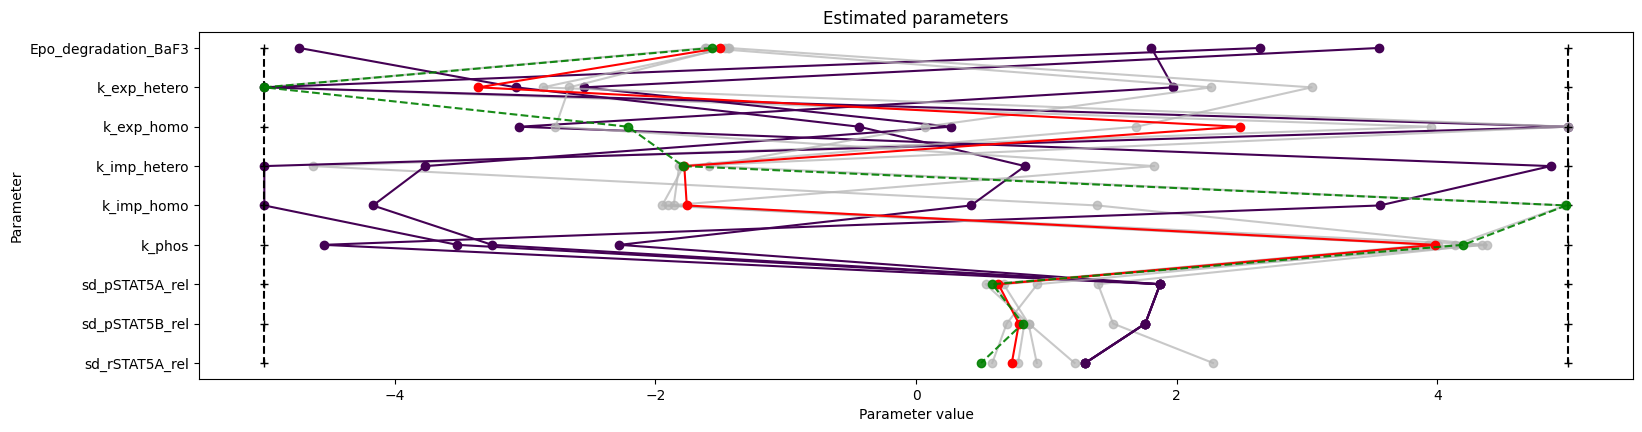

In [14]:
ref = visualize.create_references(
    x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled)
)

visualize.waterfall(result, reference=ref, scale_y="lin")
visualize.parameters(result, reference=ref)

We can also conveniently visualize the model fit. This plots the petab visualization using optimized parameters.

{'plot1': <AxesSubplot: title={'center': 'pSTAT5A_rel'}, xlabel='Time [min]', ylabel='frac. [%]'>,
 'plot2': <AxesSubplot: title={'center': 'pSTAT5B_rel'}, xlabel='Time [min]', ylabel='frac. [%]'>,
 'plot3': <AxesSubplot: title={'center': 'rSTAT5A_rel'}, xlabel='Time [min]', ylabel='relative STAT5A abundance [%]'>}

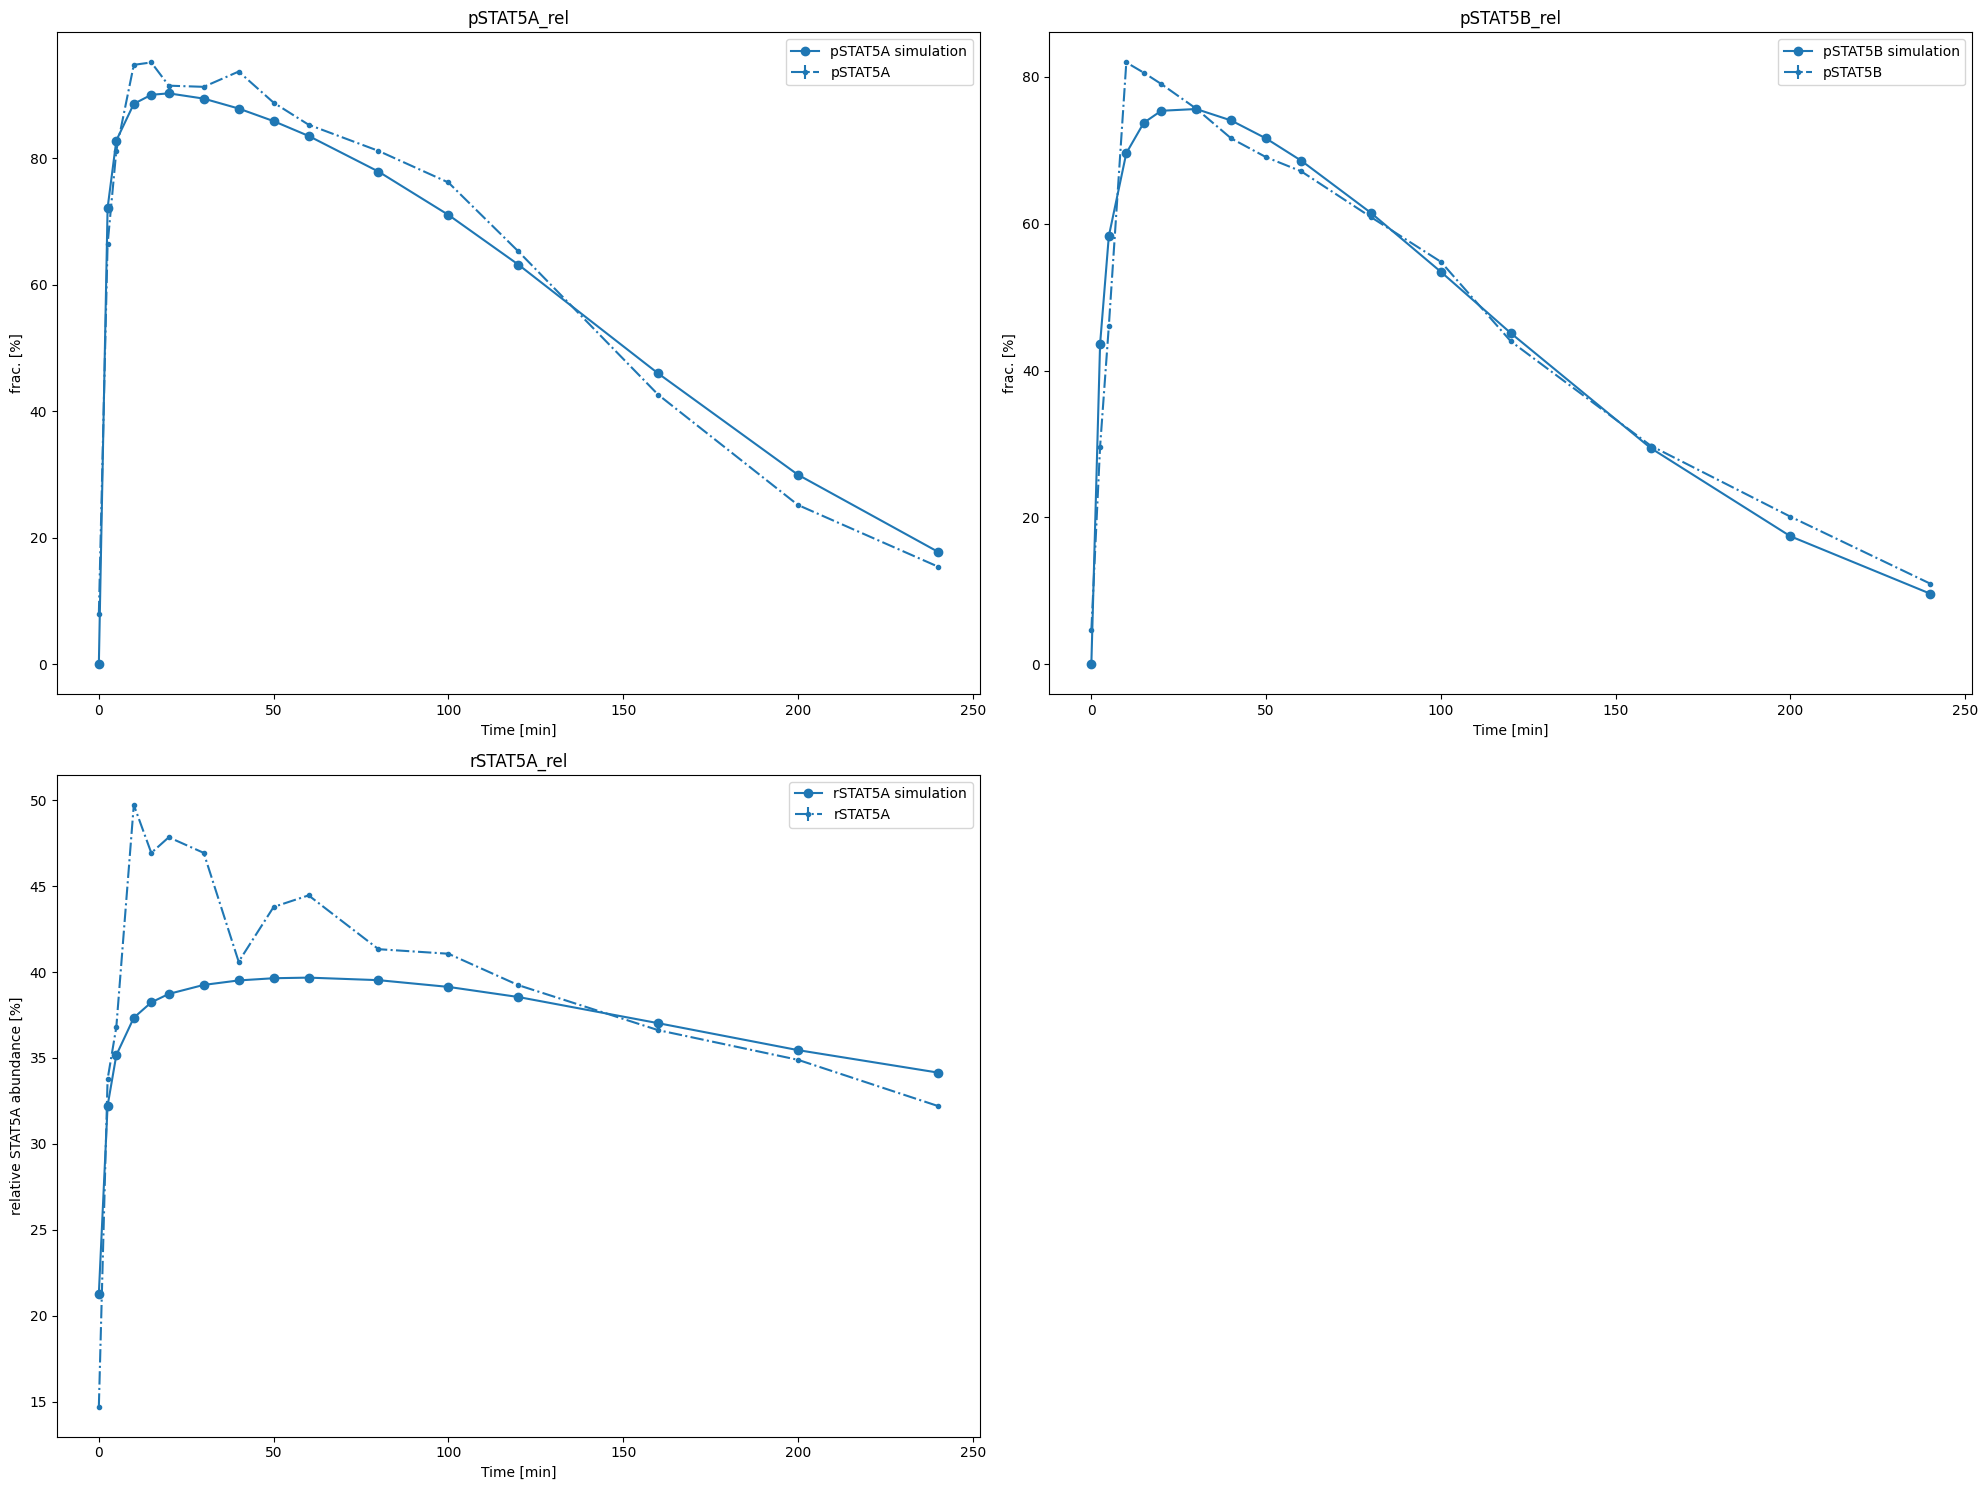

In [15]:
# we need to explicitely import the method
from pypesto.visualize.model_fit import visualize_optimized_model_fit

visualize_optimized_model_fit(
    petab_problem=petab_problem, result=result, pypesto_problem=problem
)